In [27]:
from stage1 import *

In [28]:
nframes,natoms,nmols=(0,0,0)

In [29]:
from stage2 import * 

In [30]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [31]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [32]:
cf=condenseframe(testframe)

In [33]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

50001 4 592


In [34]:
cf

array([[ 784.57624268,  -93.61405064, -156.63581845,    2.28225017,
           0.95225006,    1.95350003],
       [ 779.80309936,  -93.0955292 , -155.6282712 ,    1.36549997,
           1.45650005,    2.59900022],
       [ 875.98538323, -105.72439904, -174.73795757,    0.83375001,
           1.77175009,    0.73750007],
       ...,
       [ 741.20094106,  -88.34534765, -147.99184888,    2.56474996,
           1.57500005,    2.47574997],
       [ 757.66172186,  -90.34700559, -151.26807672,    1.61825013,
           1.92200017,    2.49900007],
       [ 803.44132066,  -96.45390954, -160.33241851,    0.79150009,
           2.24175   ,    2.16525006]])

In [35]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:02<00:00, 22.02it/s]

30192


In [36]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [37]:
g = get_graph(cf,1,n_neigh,"cry")

In [38]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [39]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 100
batch_size=256
test_train_split = 0.8
model_name = "Interex1.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [40]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 30192/30192 [00:22<00:00, 1345.62it/s]


In [41]:
graphs = graphs_device
total_graphs = len(graphs)


In [42]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 30192
batch Size: 256
number of batches: 117
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [43]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [44]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()

def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        loss = MSE_loss(decoded_x, data.x)
        loss.backward()
        all_loss_mse += float(loss)
        optimizer.step()


    return all_loss_mse/len(train_loader)

In [45]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [46]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 4131.5500
	Test: 	MSE Loss: 4166.9378
Epoch: 002
	Train:	MSE Loss: 3728.6431
	Test: 	MSE Loss: 4102.1203
Epoch: 003
	Train:	MSE Loss: 3882.7510
	Test: 	MSE Loss: 4043.5991
Epoch: 004
	Train:	MSE Loss: 3682.2930
	Test: 	MSE Loss: 4022.5531
Epoch: 005
	Train:	MSE Loss: 3524.2554
	Test: 	MSE Loss: 3933.2514
Epoch: 006
	Train:	MSE Loss: 3551.8332
	Test: 	MSE Loss: 3866.5431
Epoch: 007
	Train:	MSE Loss: 3478.9838
	Test: 	MSE Loss: 3792.6351
Epoch: 008
	Train:	MSE Loss: 3406.3583
	Test: 	MSE Loss: 3734.2123
Epoch: 009
	Train:	MSE Loss: 3431.9056
	Test: 	MSE Loss: 3679.4460
Epoch: 010
	Train:	MSE Loss: 3296.3770
	Test: 	MSE Loss: 3552.1701
Epoch: 011
	Train:	MSE Loss: 3076.0655
	Test: 	MSE Loss: 3498.0983
Epoch: 012
	Train:	MSE Loss: 3030.8684
	Test: 	MSE Loss: 3463.0794
Epoch: 013
	Train:	MSE Loss: 2962.9110
	Test: 	MSE Loss: 3359.8144
Epoch: 014
	Train:	MSE Loss: 2847.8009
	Test: 	MSE Loss: 3262.0579
Epoch: 015
	Train:	MSE Loss: 2766.5176
	Test: 	MSE Loss: 3199.

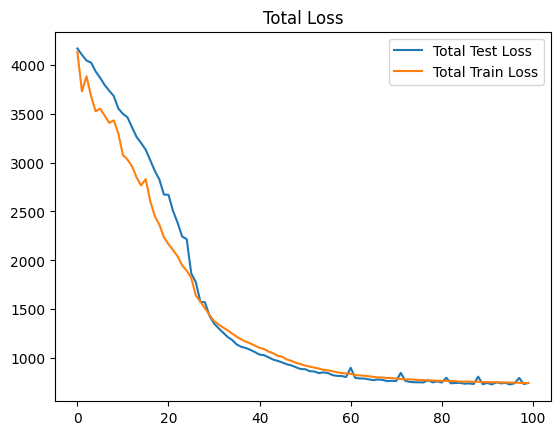

In [47]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

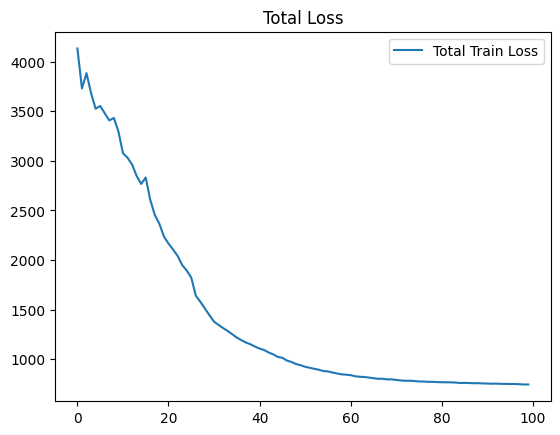

In [48]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

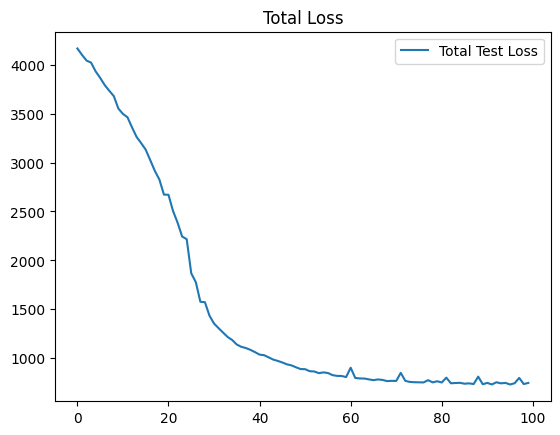

In [49]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [50]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()



    avg1 += Error_wo_s

print("Average Error", avg1/len(test_loader))


Average Error 336.07095474006974


In [51]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
# len(input_feature[0][heavy_indices])

(tensor([[-2.7848,  2.7309, -3.1041, 15.6088, 17.0096, 16.0192],
         [-0.1902, -3.5414, -6.5491, 15.4044, 15.9775, 15.0953],
         [-0.1900, -3.5424, -6.5508, 15.4035, 15.9764, 15.0945],
         [-0.1899, -3.5429, -6.5516, 15.4031, 15.9759, 15.0941],
         [-0.1904, -3.5397, -6.5464, 15.4059, 15.9792, 15.0965],
         [-0.1904, -3.5393, -6.5458, 15.4062, 15.9796, 15.0968],
         [-0.1902, -3.5413, -6.5490, 15.4045, 15.9775, 15.0953],
         [-0.1899, -3.5430, -6.5517, 15.4030, 15.9758, 15.0941],
         [-0.1901, -3.5415, -6.5493, 15.4043, 15.9773, 15.0952],
         [-0.1899, -3.5435, -6.5525, 15.4026, 15.9753, 15.0937],
         [-0.1900, -3.5427, -6.5512, 15.4033, 15.9761, 15.0943],
         [-0.1899, -3.5434, -6.5523, 15.4027, 15.9754, 15.0938],
         [-0.1899, -3.5430, -6.5516, 15.4031, 15.9759, 15.0941],
         [-0.1900, -3.5424, -6.5507, 15.4035, 15.9764, 15.0945],
         [-0.1902, -3.5410, -6.5484, 15.4048, 15.9779, 15.0956],
         [-0.1899, -3.543

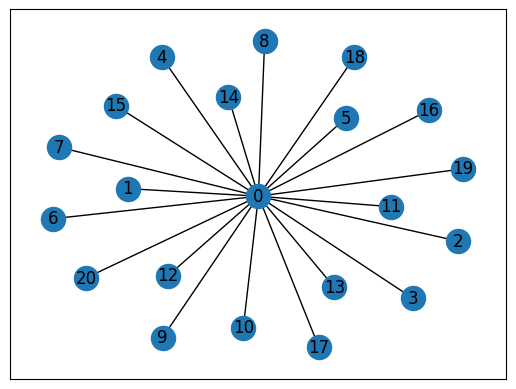

In [52]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()
